# Continuum model tutorial (regular grid)
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/17/2023          |
| Updated |  08/24/2023          |

Followed from the [radmc3dPy tutorial](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_rmcpy/tutorial_reggrid_cont.html)

## Model setup

In [3]:
from radmc3dPy import *
# analyze, image, setup, natconst, models

In [4]:
models.getModelNames()

['lines_nlte_lvg_1d_1',
 'ppdisk',
 'ppdisk_acc',
 'ppdisk_amr',
 'simple_1',
 'spher1d_1',
 'spher2d_1']

In [5]:
models.getModelDesc('ppdisk')

'Generic protoplanetary disk model'

In [6]:
analyze.writeDefaultParfile('ppdisk')

Writing problem_params.inp


In [7]:
par = analyze.readParams()
par.printPar()

# -------------------------------------------------------------------------------------------------------------------------
# Block: Radiation sources
# -------------------------------------------------------------------------------------------------------------------------
incl_cont_stellarsrc      = False  # # Switches on (True) or off (False) continuous stellar sources )
incl_disc_stellarsrc      = True  # # Switches on (True) or off (False) discrete stellar sources)
mstar                     = [1.0*ms]  # # Mass of the star(s)
pstar                     = [0.0, 0.0, 0.0]  # # Position of the star(s) (cartesian coordinates)
rstar                     = [2.0*rs]  # # Radius of the star(s)
staremis_type             = ["blackbody"]  # # Stellar emission type ("blackbody", "kurucz", "nextgen")
tstar                     = [4000.0]  # # Effective temperature of the star(s) [K]
# -----------------------------------------------------------------------------------------------------------------

## Simple setup

**NOTE:** As of Aug. 24, 2023, the command immediately below requires `numpy<=1.19.5` to avoid errors that use of `np.int` is deprecated as of `numpy>=1.20`.

In [8]:
setup.problemSetupDust('ppdisk', mdisk='1e-5*ms', gap_rin='[10.0*au]', gap_rout='[40.*au]', gap_drfact='[1e-5]', nz='0')

Writing problem_params.inp
Writing dustopac.inp
Writing wavelength_micron.inp
Writing amr_grid.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing dust_density.binp
Writing radmc3d.inp


## Modular setup

In [9]:
import radmc3dPy
model = radmc3dPy.setup.radmc3dModel(model='ppdisk', mdisk='1e-5*ms', gap_rin='[10.0*au]', gap_rout='[40.*au]', gap_drfact='[1e-5]', nz='0')

Writing problem_params.inp


In [10]:
model.writeRadmc3dInp()

Writing radmc3d.inp


In [11]:
model.makeGrid(writeToFile=True)

Writing wavelength_micron.inp
Writing amr_grid.inp


In [12]:
model.makeRadSources(writeToFile=True)

Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------


In [13]:
model.makeDustOpac()

Writing dustopac.inp


In [14]:
model.makeVar(ddens=True, writeToFile=True)

Writing dust_density.binp


## Read the model structure

In [15]:
data = analyze.readData(ddens=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.binp


## Diagnostic plots

In [16]:
import matplotlib.pylab as plb
import numpy as np

### Dust density contours

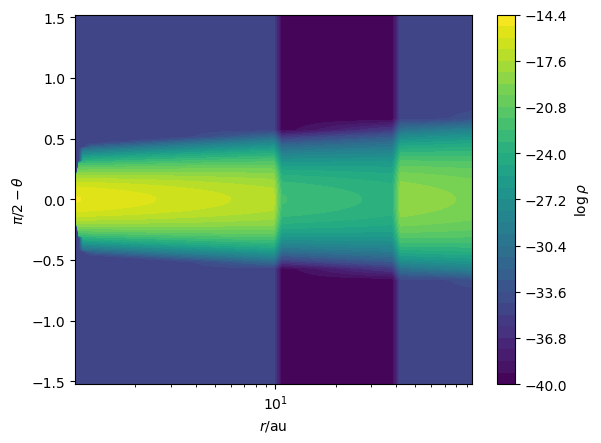

In [17]:
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, np.log10(data.rhodust[:,:,0,0].T), 30)
plb.xlabel('$r$/au')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')
cb = plb.colorbar(c)
cb.set_label(r'$\log\rho$')#, rotation=270.)

### Dust opacity

In [18]:
opac = analyze.readOpac(ext=['silicate'])

Reading dustkappa_silicate.inp


In [19]:
opac = analyze.readOpac(idust=[0])

Reading dustkappa_silicate.inp


In [20]:
opac.idust

[0]

Text(0, 0.5, '$\\kappa_{\\rm abs}$ [cm$^2$/g]')

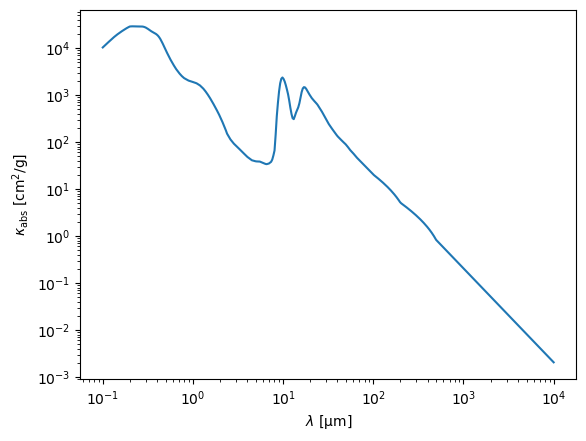

In [21]:
plb.loglog(opac.wav[0], opac.kabs[0])
plb.xlabel(r'$\lambda$ [$\rm{\mu}$m]')
plb.ylabel(r'$\kappa_{\rm abs}$ [cm$^2$/g]')

### Optical depth

In [22]:
data.getTau(wav=0.5)

Reading dustkappa_silicate.inp
Opacity at 0.50um :  28460.764433351476


<a list of 1 text.Text objects>

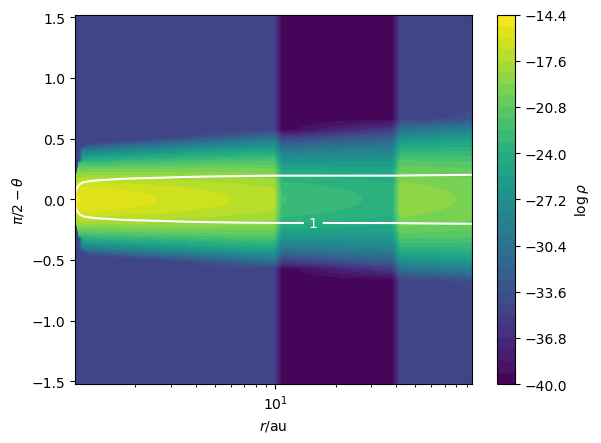

In [23]:
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, np.log10(data.rhodust[:,:,0,0].T), 30)
plb.xlabel('$r$/au')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')
cb = plb.colorbar(c)
cb.set_label(r'$\log\rho$')#, rotation=270.)

c = plb.contour(data.grid.x/natconst.au, np.pi/2.-data.grid.y, data.taux[:,:,0].T, [1.0], colors='w', linestyles='solid')
plb.clabel(c, inline=1)

### Run the thermal MC

**NOTE:** To run RADMC-3D in thermal MC mode (i.e., compute the dust temperatures using the Monte Carlo method) on parallel threads with OpenMP, use `setthreads [num]` (see [Additional arguments: general](https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_radmc3d/clioptions.html?highlight=openmp#additional-arguments-general))

In [24]:
import os
os.system('radmc3d mctherm setthreads 10')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

0

### Dust temperature contours

In [25]:
data = analyze.readData(dtemp=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_temperature.bdat


In [26]:
data.readDustTemp()

Reading dust_temperature.bdat


<a list of 10 text.Text objects>

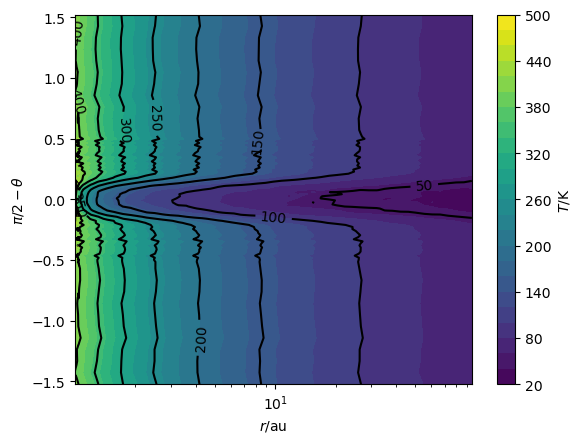

In [27]:
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, data.dusttemp[:,:,0,0].T, 30)
plb.xlabel('$r$/au')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')
cb = plb.colorbar(c)
cb.set_label('$T$/K')#, rotation=270.)

c = plb.contour(data.grid.x/natconst.au, np.pi/2.-data.grid.y, data.dusttemp[:,:,0,0].T, 10,  colors='k', linestyles='solid')
plb.clabel(c)

### Convenient 2D contour plots

In [28]:
data = analyze.readData(ddens=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.binp


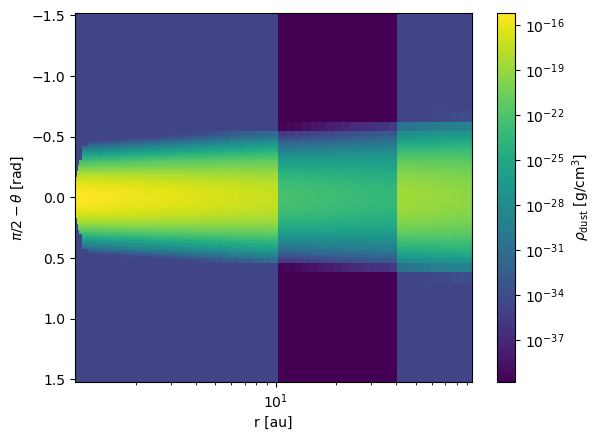

In [29]:
analyze.plotSlice2D(data, var='ddens', plane='xy', log=True, linunit='au')#, cmap=plb.cm.jet)
plb.xscale('log')

Reading dustkappa_silicate.inp
Opacity at 0.50um :  28460.764433351476


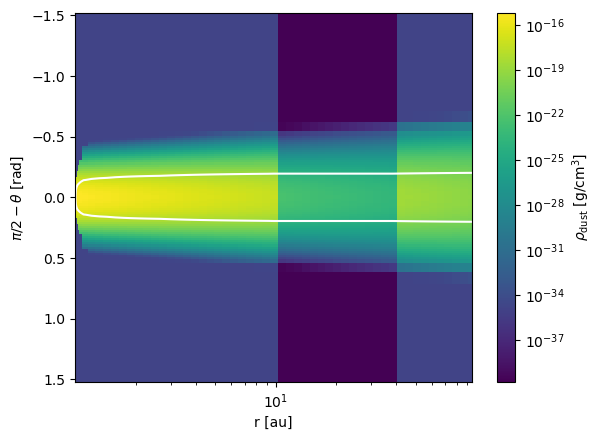

In [31]:
analyze.plotSlice2D(data, var='ddens', plane='xy', log=True, linunit='au')#, cmap=plb.cm.jet)
plb.xscale('log')
data.getTau(wav=0.5)
analyze.plotSlice2D(data, var='taux', plane='xy', log=True, linunit='au', contours=True, clev=[1.0], clcol='w')

Reading dustkappa_silicate.inp
Opacity at 0.50um :  28460.764433351476
Reading dust_temperature.bdat


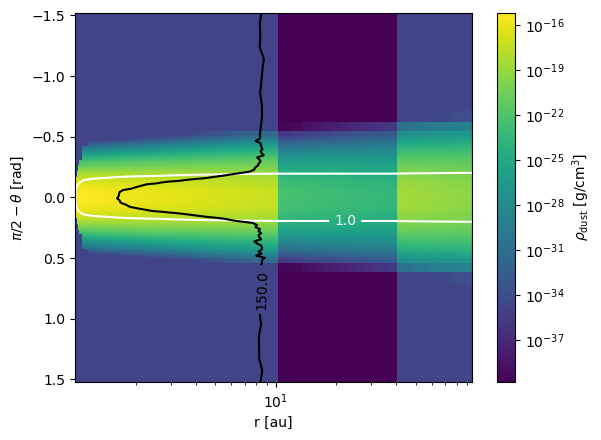

In [34]:
analyze.plotSlice2D(data, var='ddens', plane='xy', log=True, linunit='au')#, cmap=plb.cm.jet)
plb.xscale('log')
data.getTau(wav=0.5)
analyze.plotSlice2D(data, var='taux', plane='xy', log=True, linunit='au', contours=True, clev=[1.0], clcol='w', cllabel=True)
data.readDustTemp()
analyze.plotSlice2D(data, var='dtemp', plane='xy', ispec=0, log=True, linunit='au', contours=True, clev=[150.0], clcol='k', cllabel=True)

## Images

### Make an image

In [35]:
image.makeImage(npix=300., wav=2.2, incl=20., phi=0., sizeau=300.)

Executing RADMC-3D Command:
radmc3d image npix 300 incl 20.0 sizeau 300.0 lambda 2.2 phi 0.0 pointau 0.0  0.0  0.0 fluxcons
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            htt

0

### Display images

Reading image.out


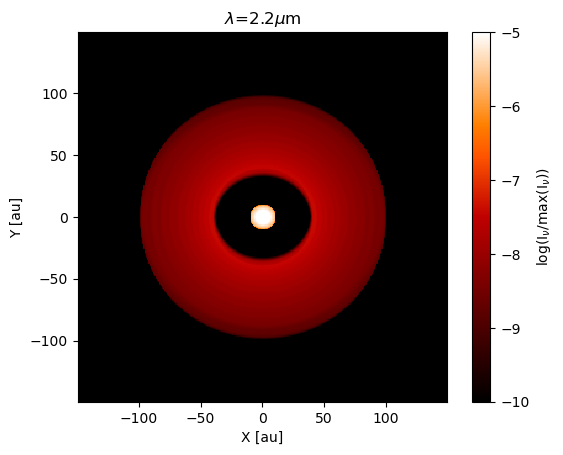

{'implot': <matplotlib.image.AxesImage at 0x7f9cdf215400>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f9cdf1fd6d0>}

In [39]:
im = image.readImage()
image.plotImage(im, au=True, log=True, maxlog=10, saturate=1e-5, cmap=plb.cm.gist_heat)

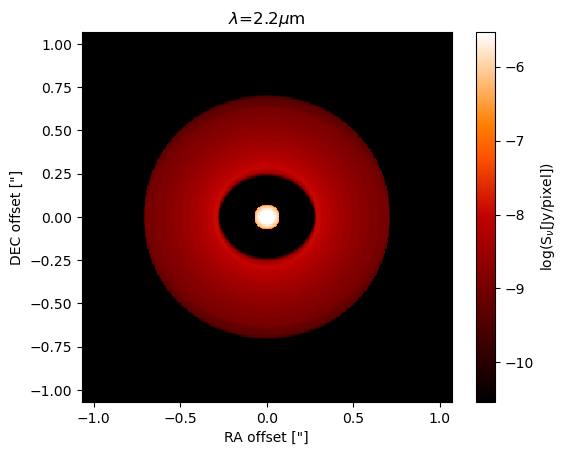

{'implot': <matplotlib.image.AxesImage at 0x7f9cdf3d3370>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f9cdf3d3a30>}

In [40]:
image.plotImage(im, arcsec=True, dpc=140., log=True, maxlog=10, saturate=1e-5, bunit='snu', cmap=plb.cm.gist_heat)

### Image manipulations

#### Gaussian-beam convolution
Use the `bunit='jy/pixel` keyword to display the image in units of Jy/pixel. The bunit='snu' is kept for backward compatibility for now. 

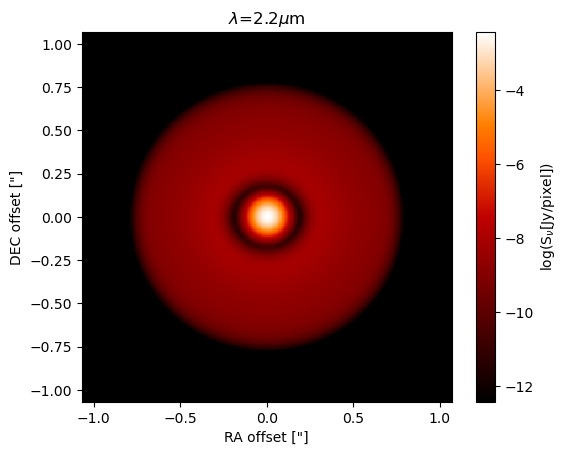

{'implot': <matplotlib.image.AxesImage at 0x7f9cdf4ff700>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f9cdf3fd4c0>}

In [41]:
cim = im.imConv(fwhm=[0.06, 0.06], pa=0., dpc=140.)
image.plotImage(cim, arcsec=True, dpc=140., log=True, maxlog=10, bunit='jy/beam', cmap=plb.cm.gist_heat)

#### Coronographic mask

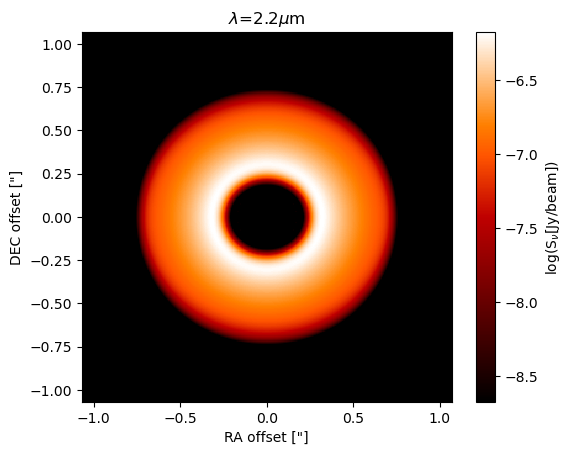

{'implot': <matplotlib.image.AxesImage at 0x7f9cdf5710a0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f9cdf571580>}

In [43]:
image.plotImage(cim, arcsec=True, dpc=140., log=True, maxlog=2.5, bunit='jy/beam', cmask_rad=0.17, cmap=plb.cm.gist_heat)

### Writing images to fits

In [44]:
im.writeFits('myimage.fits', dpc=140., coord='03h10m05s -10d05m30s')